# CNN Classifier

- Data: https://www.kaggle.com/datasets/phucthaiv02/butterfly-image-classification?resource=download

In [1]:
# General imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

2024-01-14 17:42:19.273276: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Explore data

In [2]:
data_path = '../data/'

### Visualise a butterfly from the dataset

Image size: (224, 224, 3)


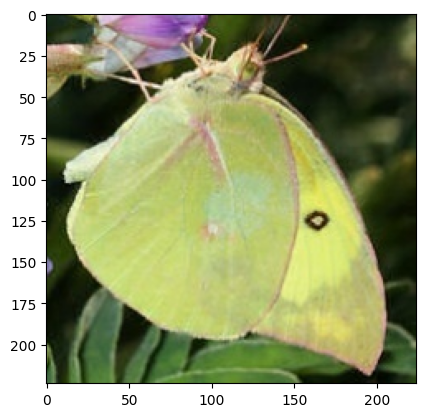

In [3]:
from PIL import Image

# Visualise image
image = np.asarray(Image.open(data_path+'train/Image_1.jpg'))
imgplot = plt.imshow(image)

print('Image size:', image.shape)
image_size = image.shape[0]

### Inspect CSV files

These files contain information of what is in the train and test folders of the data

In [4]:
train_df = pd.read_csv(data_path+'Training_set.csv')
print(train_df.shape)
train_df.head()

(6499, 2)


filename                     label
0  Image_1.jpg          SOUTHERN DOGFACE
1  Image_2.jpg                    ADONIS
2  Image_3.jpg            BROWN SIPROETA
3  Image_4.jpg                   MONARCH
4  Image_5.jpg  GREEN CELLED CATTLEHEART

In [5]:
test_df = pd.read_csv(data_path+'Testing_set.csv')
print(test_df.shape)
test_df.head()

(2786, 1)


filename
0  Image_1.jpg
1  Image_2.jpg
2  Image_3.jpg
3  Image_4.jpg
4  Image_5.jpg

Conclusion: We'll only work with data from the train folder as data in the test folder is unlabeled.

### Visualise distribution of classes in dataset

In this way we can retrive information about how balanced the dataset is

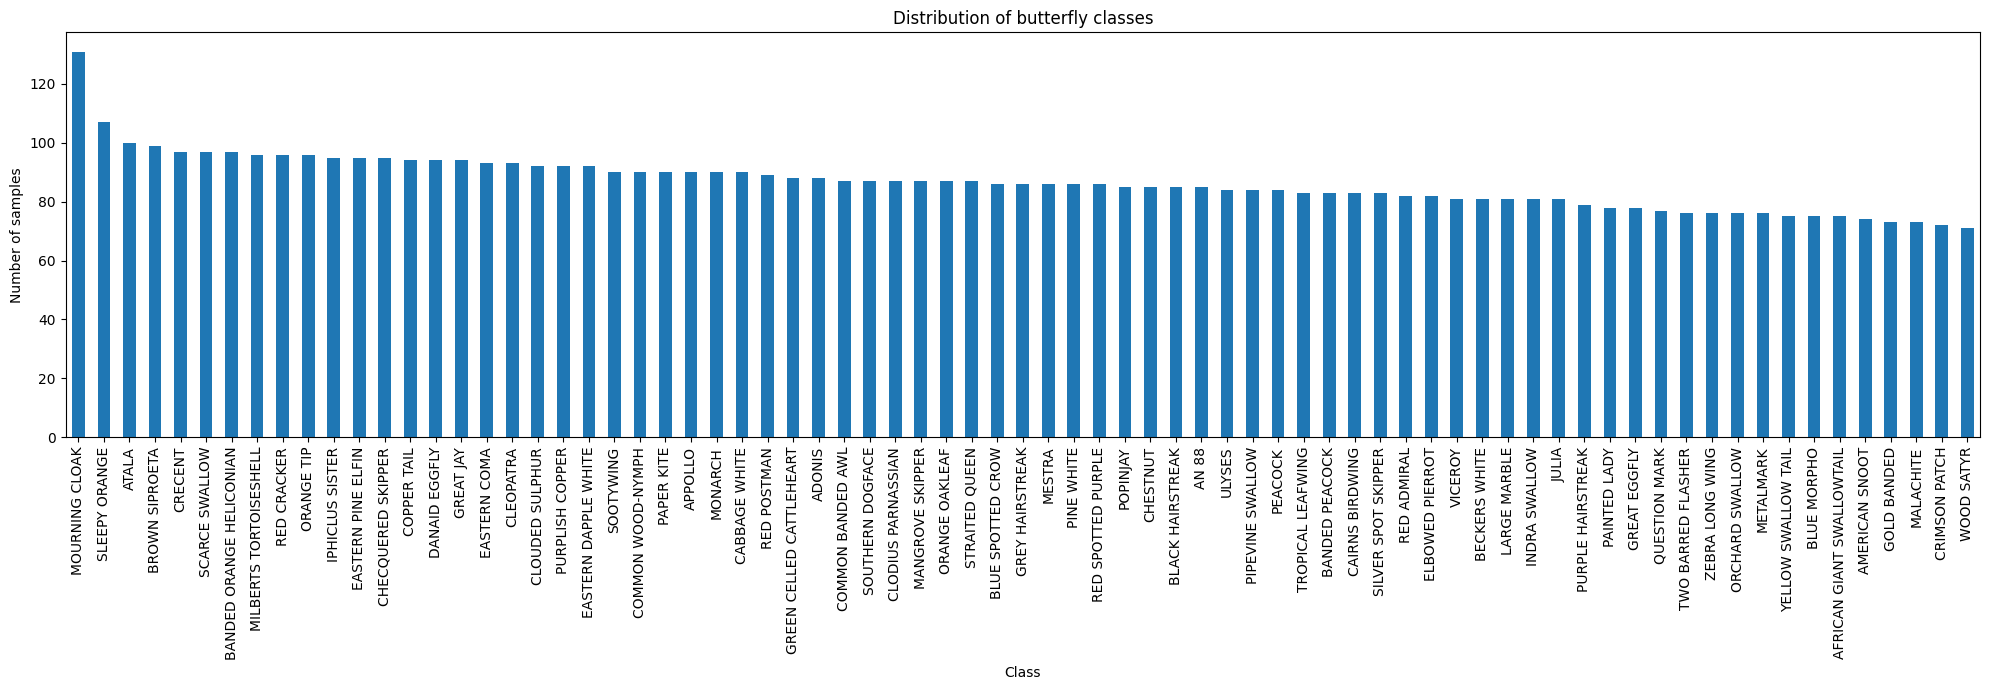

In [6]:
# Rename as we'll only use data in the train folder
data_df = train_df
data_path = data_path + 'train'

def plot_dist(df):
    # Plot distribution of butterfly classes
    plt.figure(figsize=(20, 7))
    df['label'].value_counts().plot(kind='bar')
    plt.title('Distribution of butterfly classes')
    plt.xlabel('Class')
    plt.ylabel('Number of samples')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
    
plot_dist(data_df)

Conclusion: Dataset is reasonably balanced, techniques for handling imbalanced datasets will not be necessary

# Preprocess data

## Split datasets

In [7]:
from sklearn.model_selection import train_test_split

# Split data into train and validation sets
train_df, val_df = train_test_split(data_df, test_size=0.2, random_state=45) # Use 20% test set size

print(train_df.shape)
print(val_df.shape)

(5199, 2)
(1300, 2)


### Check that datasets are still balanced after split

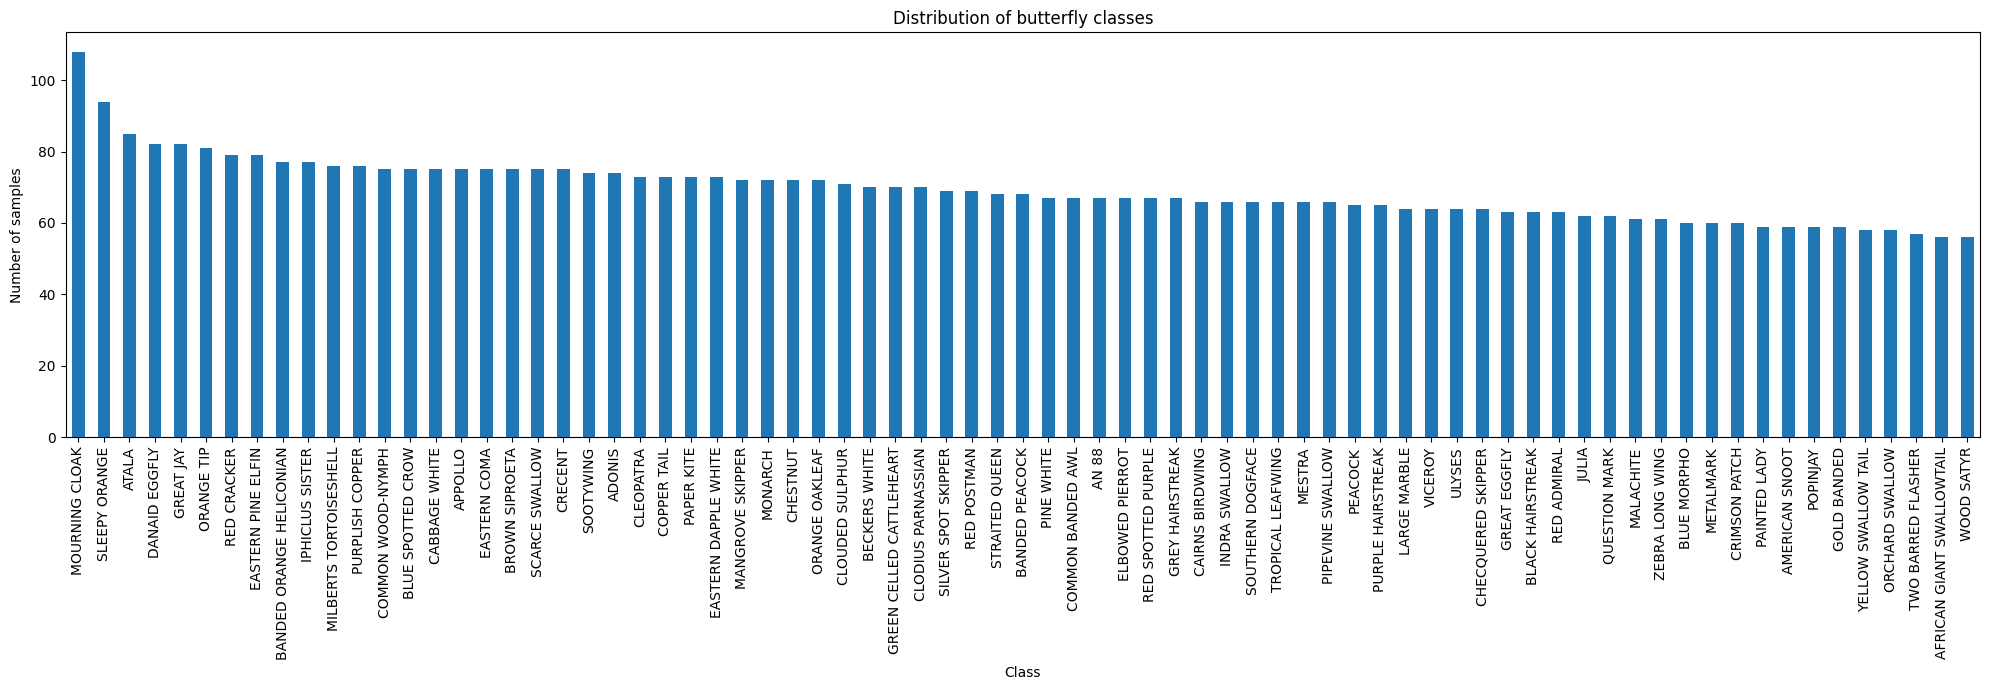

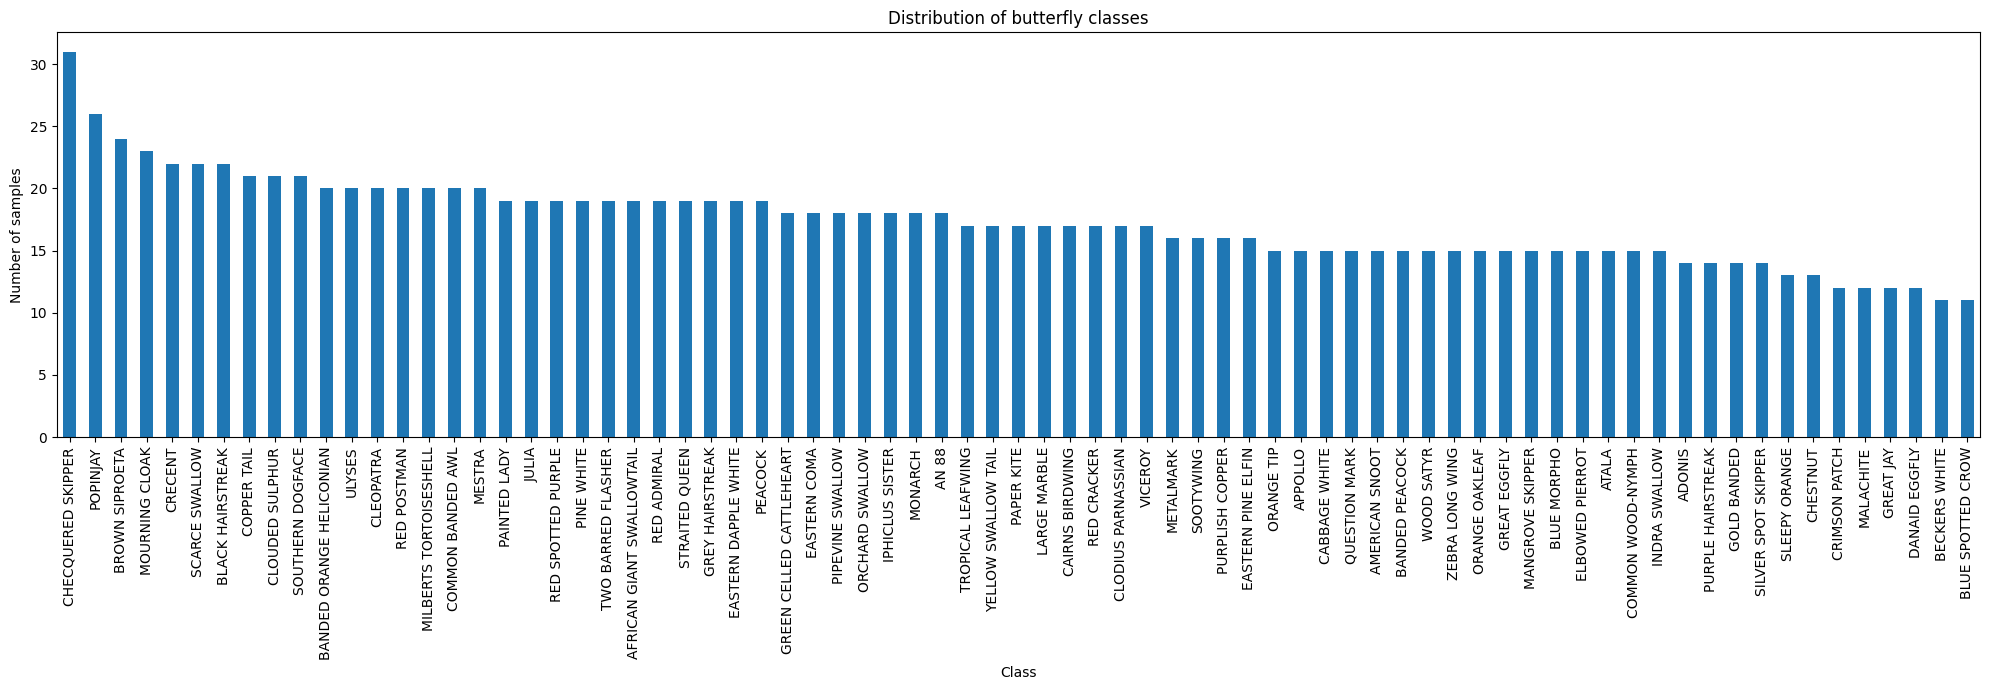

In [8]:
# Plot distribution of butterfly classes in training set
plot_dist(train_df)

# Plot distribution of butterfly classes in validation set
plot_dist(val_df)


Conslusion: They still keep the same reasonably balanced distribution

## Perform augmentation/resampling on train data

Use ImageDataGenerator for augmenting the training data, this way we resample the trainingdata to let information about patterns and shapes contained in the images be fed to the model during training in varying forms

Also normalize (rescale) all data which may help improve performance and stability of the CNN model.

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
batch_size = 32
target_size = (128, 128) # Downsize from 224 to improve training speed

# For description of args used see
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#args
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

train_gen = train_datagen.flow_from_dataframe(
    dataframe = train_df,
    directory = data_path,
    x_col ='filename',
    y_col ='label', 
    target_size = target_size,
    batch_size = batch_size,
    seed = 123,
    class_mode = 'categorical')


# Do only resclaing (normalization) of validation dataset
val_datagen = ImageDataGenerator(rescale=1./255)

val_gen = val_datagen.flow_from_dataframe(
    dataframe = val_df,
    directory = data_path,
    x_col ='filename',
    y_col ='label', 
    target_size = target_size,
    batch_size = batch_size,
    seed = 123,
    class_mode = 'categorical',
    shuffle=False) # Do not shuffle validation set, important for later confusion matrix to be correct

Found 5199 validated image filenames belonging to 75 classes.
Found 1300 validated image filenames belonging to 75 classes.


# Construct model

Inspired by the VGG16 model, a small CNN model known for its simplicity and has shown good performance on a variety of image classification tasks

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras import callbacks

input_shape = (*target_size, 3)
num_classes = 75


# Define the model
model = Sequential()

# Convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten layer
model.add(Flatten())

# Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Dropout for regularization

# Output layer
model.add(Dense(num_classes, activation='softmax'))

# Apply early stopping to prevent overfitting
early_stopping = callbacks.EarlyStopping(monitor='val_loss', 
                                         min_delta=0.0001, patience=5, verbose=1, mode='auto')


# Compile model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Save train model and save its history
history = model.fit(train_gen, validation_data=val_gen, epochs=30, verbose=1, callbacks=[early_stopping])

Epoch 1/30
163/163 [==============================] - 73s 437ms/step - loss: 4.3252 - accuracy: 0.0273 - val_loss: 4.0202 - val_accuracy: 0.0346
Epoch 2/30
163/163 [==============================] - 65s 399ms/step - loss: 3.8677 - accuracy: 0.0735 - val_loss: 3.3141 - val_accuracy: 0.1808
Epoch 3/30
163/163 [==============================] - 65s 400ms/step - loss: 3.3678 - accuracy: 0.1558 - val_loss: 2.7536 - val_accuracy: 0.3046
Epoch 4/30
163/163 [==============================] - 70s 430ms/step - loss: 3.0344 - accuracy: 0.2220 - val_loss: 2.4005 - val_accuracy: 0.3885
Epoch 5/30
163/163 [==============================] - 64s 390ms/step - loss: 2.7823 - accuracy: 0.2583 - val_loss: 2.3225 - val_accuracy: 0.4115
Epoch 6/30
163/163 [==============================] - 64s 389ms/step - loss: 2.6227 - accuracy: 0.2818 - val_loss: 2.1085 - val_accuracy: 0.4415
Epoch 7/30
163/163 [==============================] - 67s 412ms/step - loss: 2.5133 - accuracy: 0.3066 - val_loss: 1.9682 - val_ac

In [11]:
# Save the entire model to a file
model.save('butterfly_classifier_CNN.keras')

In [12]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model('butterfly_classifier_CNN.keras')

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 57600)             0         
                                                                 
 dense (Dense)               (None, 128)               7

### Plot training history

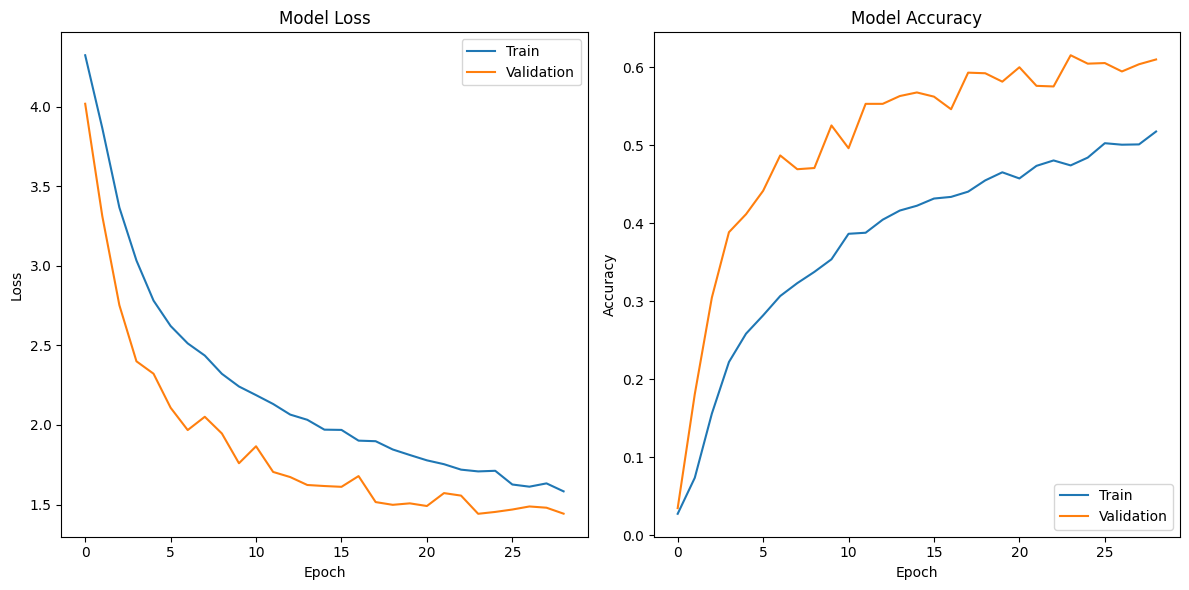

In [14]:

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.tight_layout()
plt.show()

# Model interpretation

To interpret how the model thinks when predicting the class of an image Class Activation Maps (CAM) can be used. CAM is a technique that highlights the regions of an image that were most important in making a prediction. It helps to visualize which parts of the image the model focused on for a specific class.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


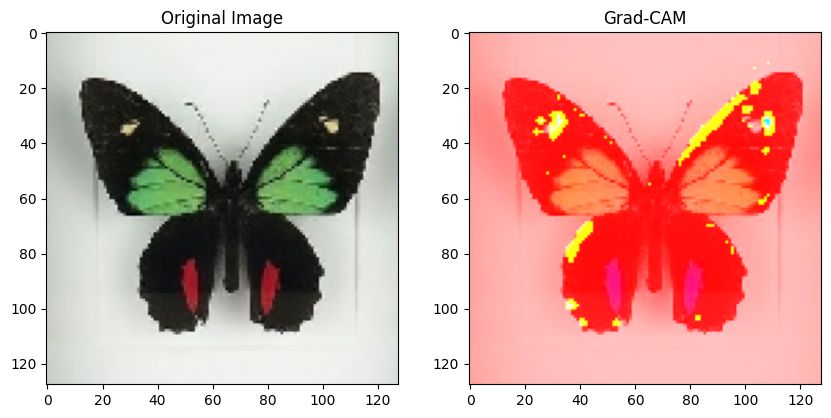

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import tensorflow as tf
import cv2

def plot_CAM(img_array):
    # Extract the last convolutional layer for Grad-CAM
    last_conv_layer = model.get_layer('conv2d_1') # Name found in model-summary

    # Create a model that maps the input image to the last conv layer's output
    grad_model = Model([model.inputs], [last_conv_layer.output, model.output])
    
    # Add dummy dimension, representing a batch
    img_array = np.expand_dims(img_array, axis=0) 


    # Get the gradients of the target class with respect to the output of the last conv layer
    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        class_idx = np.argmax(predictions[0])
        loss = predictions[:, class_idx]

    # Calculate  gradients
    grads = tape.gradient(loss, conv_output)[0]

    # Pool the gradients over each feature map
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))

    # Multiply each feature map by its importance score (pooled gradient)
    heatmap = tf.reduce_mean(tf.multiply(conv_output, pooled_grads), axis=-1)

    # Apply ReLU to the heatmap to focus on positive contributions
    heatmap = tf.maximum(heatmap, 0)

    # Normalize the heatmap
    heatmap /= tf.reduce_max(heatmap)

    # Convert to numpy array for visualization
    heatmap = heatmap.numpy()

    # Make heatmap axis be in same order as original image array
    heatmap = np.moveaxis(heatmap, 0, 2)

    # Upsample the heatmap to match the original image size
    upsampled_heatmap = tf.image.resize(heatmap, (128, 128)).numpy()

    # Superimpose the heatmap on the original image (blen original image with activation heatmap)
    superimposed_img = np.uint8(255 * upsampled_heatmap)
    superimposed_img = cv2.applyColorMap(superimposed_img, cv2.COLORMAP_JET)
    superimposed_img = superimposed_img.astype('float32')

    color_mapped_img = cv2.cvtColor(img_array[0,:,:,:], cv2.COLOR_RGB2BGR)
    superimposed_img = cv2.addWeighted(color_mapped_img, 0.8, superimposed_img, 0.3, 0)

    # Plot the original image and the superimposed image
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img_array[0,:,:,:])
    plt.title('Original Image')

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img)
    plt.title('Grad-CAM')

    plt.show()
    
    
img = val_gen[0][0][2] # Extract an image from dataset
plot_CAM(img)

# Model evaluation

## Confusion matrix

In [16]:
# Predict classes for an unseen dataset
y_pred = model.predict(val_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_gen.classes

41/41 [==============================] - 6s 137ms/step


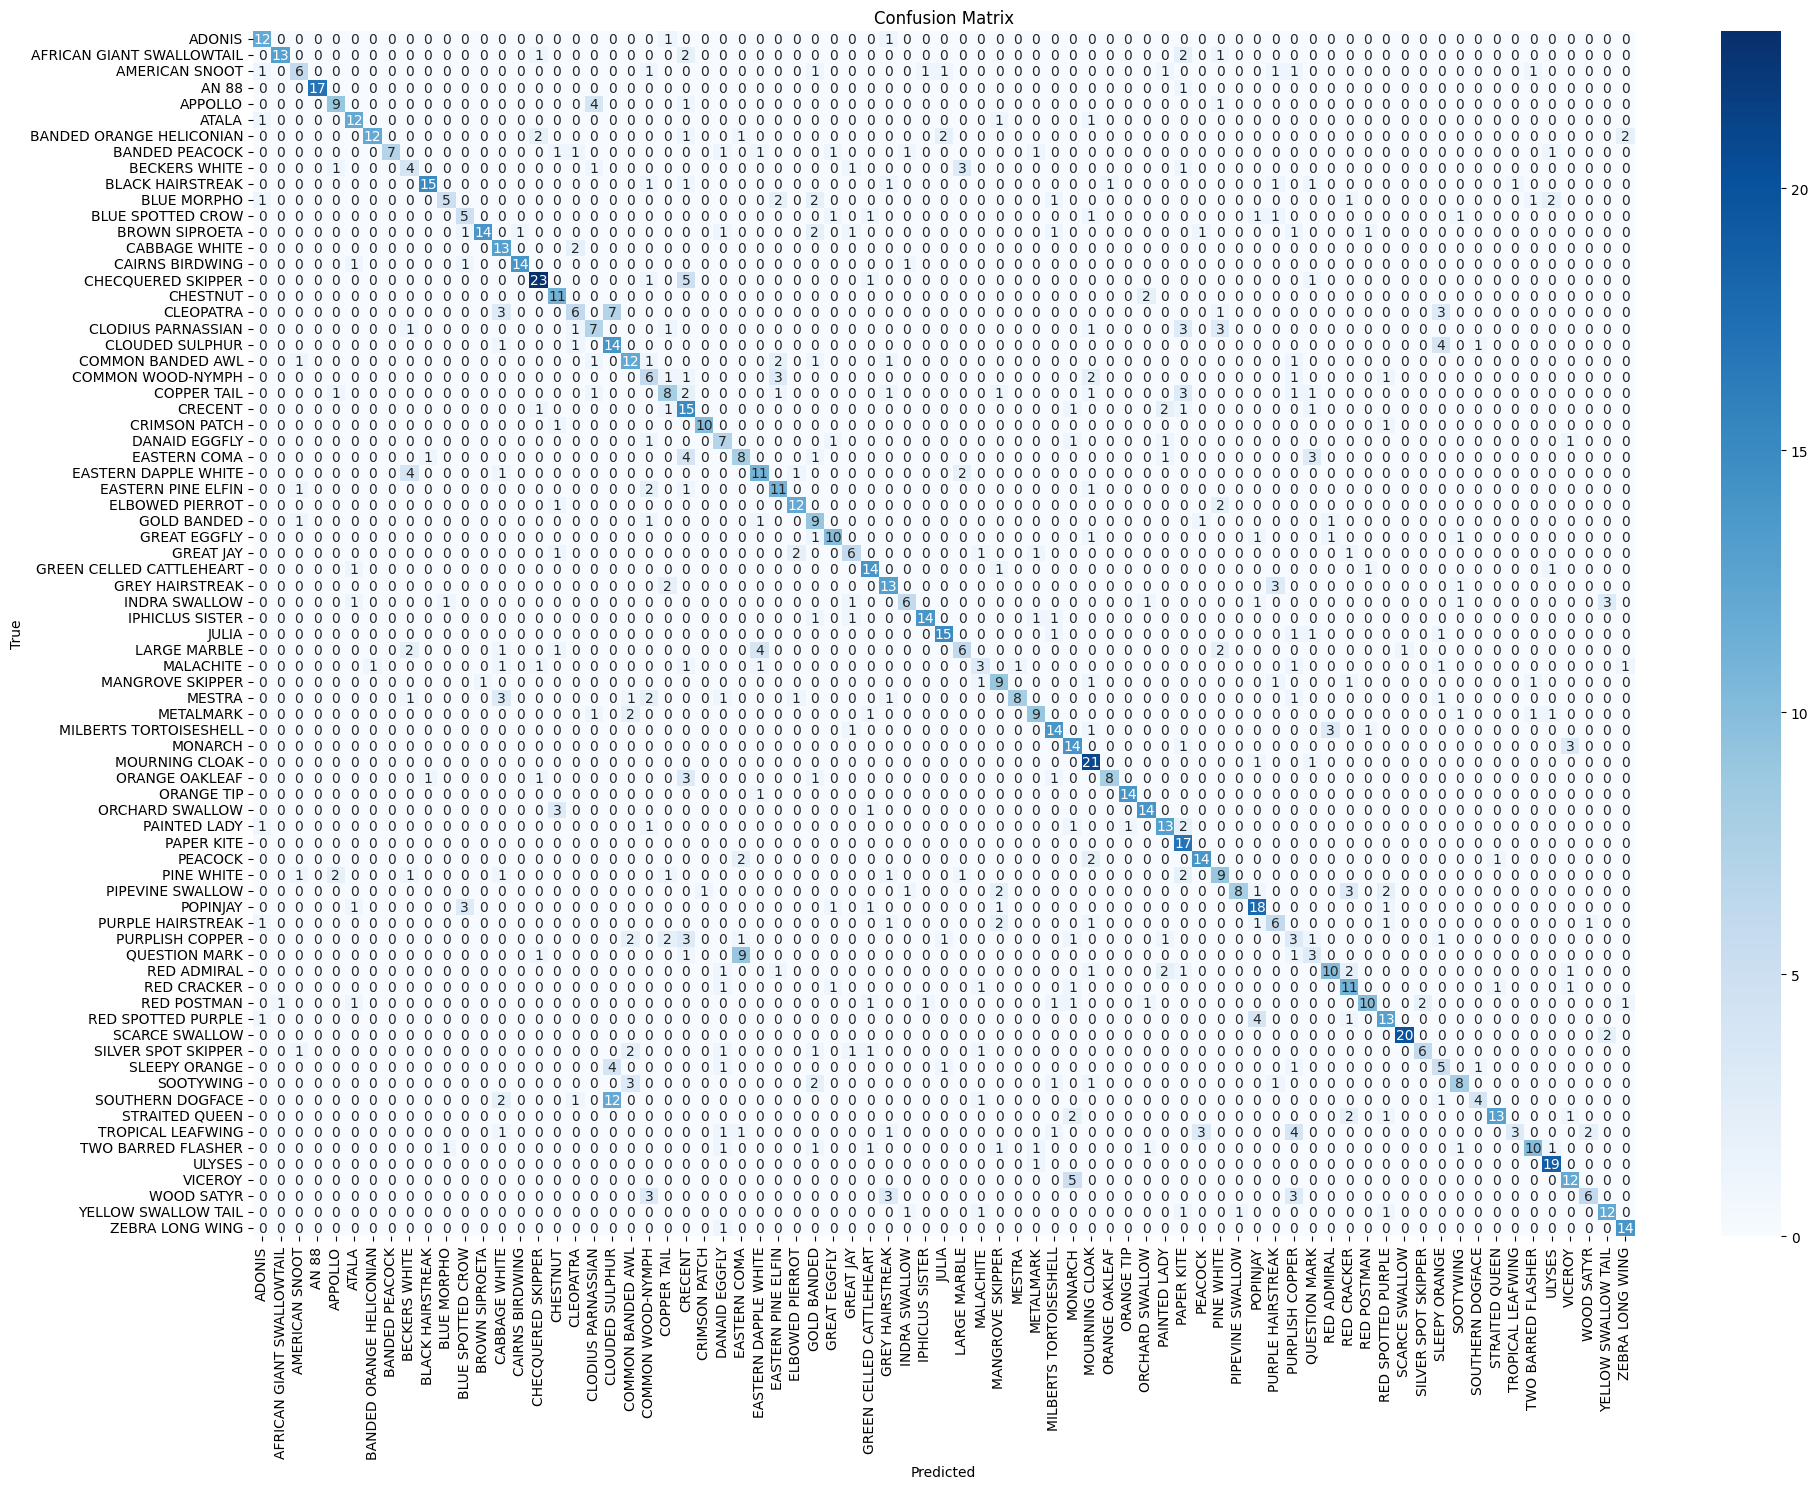

Classification Report:
                            precision    recall  f1-score   support

                   ADONIS       0.67      0.86      0.75        14
AFRICAN GIANT SWALLOWTAIL       0.93      0.68      0.79        19
           AMERICAN SNOOT       0.55      0.40      0.46        15
                    AN 88       1.00      0.94      0.97        18
                  APPOLLO       0.69      0.60      0.64        15
                    ATALA       0.71      0.80      0.75        15
 BANDED ORANGE HELICONIAN       0.92      0.60      0.73        20
           BANDED PEACOCK       1.00      0.47      0.64        15
            BECKERS WHITE       0.31      0.36      0.33        11
         BLACK HAIRSTREAK       0.88      0.68      0.77        22
              BLUE MORPHO       0.71      0.33      0.45        15
        BLUE SPOTTED CROW       0.50      0.45      0.48        11
           BROWN SIPROETA       0.93      0.58      0.72        24
            CABBAGE WHITE       0.48 

In [17]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Create a confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

class_names = list(val_gen.class_indices.keys())

# Display the confusion matrix
plt.figure(figsize=(20, 15))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


# Print a classification report
print("Classification Report:\n", classification_report(y_true, y_pred_classes, target_names=val_gen.class_indices))



# Post modelling analysis

Find hardest classes to predict by looking at which classes recieed the worst f1-score

In [18]:
metrics = classification_report(y_true, y_pred_classes, target_names=val_gen.class_indices, output_dict=True)

def extract_f1(item):
    try:
        return item[1]['f1-score']
    except:
        return 1

sorted_metrics = dict(sorted(metrics.items(), key=extract_f1))

print(sorted_metrics)

# Print the sorted metrics
for key, value in sorted_metrics.items():
    print(f'{key}: {value}\n')

{'PURPLISH COPPER': {'precision': 0.15, 'recall': 0.1875, 'f1-score': 0.16666666666666663, 'support': 16.0}, 'QUESTION MARK': {'precision': 0.23076923076923078, 'recall': 0.2, 'f1-score': 0.21428571428571427, 'support': 15.0}, 'TROPICAL LEAFWING': {'precision': 0.75, 'recall': 0.17647058823529413, 'f1-score': 0.2857142857142857, 'support': 17.0}, 'MALACHITE': {'precision': 0.3333333333333333, 'recall': 0.25, 'f1-score': 0.28571428571428575, 'support': 12.0}, 'SOUTHERN DOGFACE': {'precision': 0.6666666666666666, 'recall': 0.19047619047619047, 'f1-score': 0.2962962962962963, 'support': 21.0}, 'BECKERS WHITE': {'precision': 0.3076923076923077, 'recall': 0.36363636363636365, 'f1-score': 0.33333333333333337, 'support': 11.0}, 'SLEEPY ORANGE': {'precision': 0.29411764705882354, 'recall': 0.38461538461538464, 'f1-score': 0.33333333333333337, 'support': 13.0}, 'COMMON WOOD-NYMPH': {'precision': 0.3, 'recall': 0.4, 'f1-score': 0.34285714285714286, 'support': 15.0}, 'CLEOPATRA': {'precision': 0.

### Visualise activation patterns for some of the hardest classes to predict

In [23]:
# Find what images are of class PURPLISH COPPER
val_df[val_df['label'] == 'PURPLISH COPPER'].head()

filename            label
2891  Image_2892.jpg  PURPLISH COPPER
2429  Image_2430.jpg  PURPLISH COPPER
5931  Image_5932.jpg  PURPLISH COPPER
2230  Image_2231.jpg  PURPLISH COPPER
3760  Image_3761.jpg  PURPLISH COPPER

Plot some of those images to get a sense of how the model interprets them

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


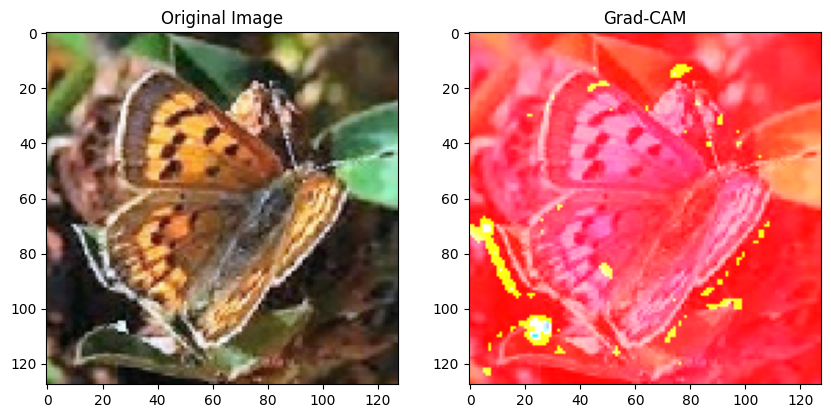

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


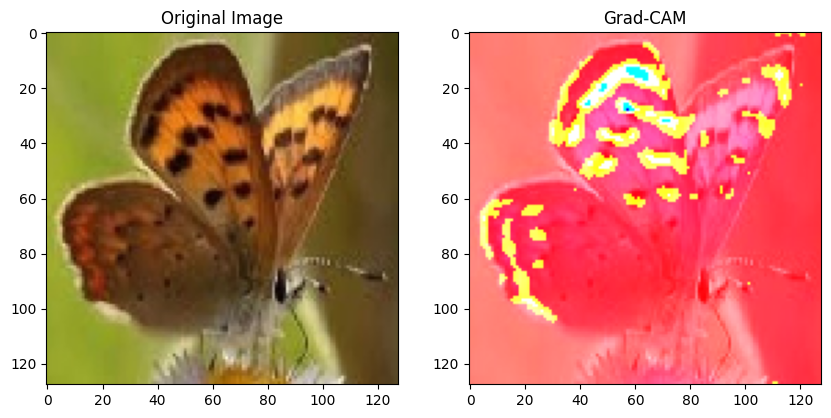

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


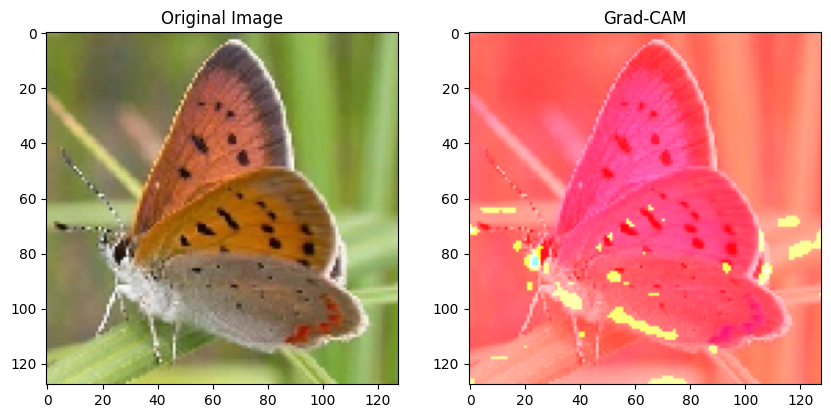

In [26]:
def plot_CAM_using_img_name(name):
    img_path = data_path + f'/{name}'
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array /= 255.0 # Normalize
    plot_CAM(img_array)
    

plot_CAM_using_img_name('Image_2231.jpg')
plot_CAM_using_img_name('Image_3761.jpg')
plot_CAM_using_img_name('Image_5932.jpg')

Conclusion: The model seems to struggle to find any clear patterns for this type of butterfly

Compare this to the butterflies the model is best at classifying, for example the ORANGE TIP

In [21]:
# Find what images are of class ORANGE TIP
val_df[val_df['label'] == 'ORANGE TIP']

filename       label
684    Image_685.jpg  ORANGE TIP
6330  Image_6331.jpg  ORANGE TIP
4079  Image_4080.jpg  ORANGE TIP
2432  Image_2433.jpg  ORANGE TIP
4053  Image_4054.jpg  ORANGE TIP
3347  Image_3348.jpg  ORANGE TIP
4150  Image_4151.jpg  ORANGE TIP
4717  Image_4718.jpg  ORANGE TIP
626    Image_627.jpg  ORANGE TIP
906    Image_907.jpg  ORANGE TIP
2632  Image_2633.jpg  ORANGE TIP
5035  Image_5036.jpg  ORANGE TIP
1338  Image_1339.jpg  ORANGE TIP
4949  Image_4950.jpg  ORANGE TIP
2596  Image_2597.jpg  ORANGE TIP

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


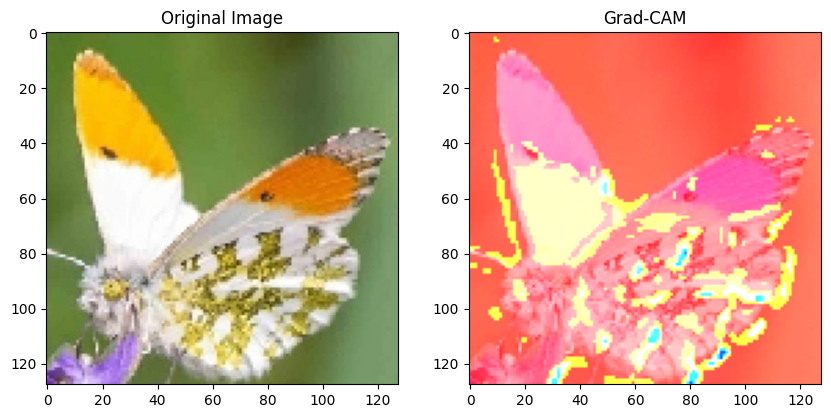

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


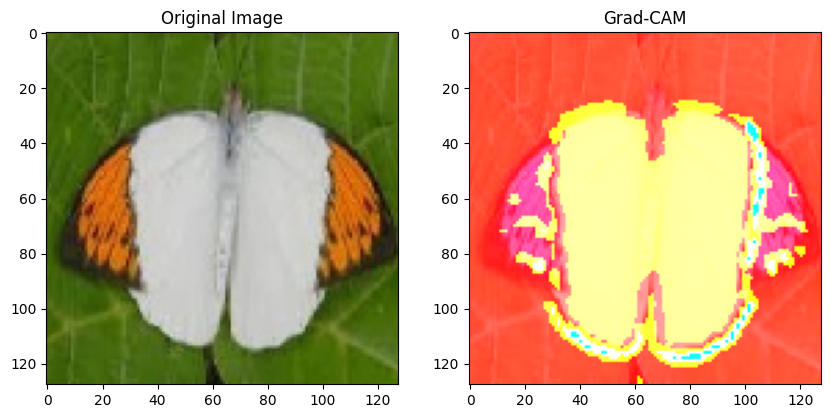

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


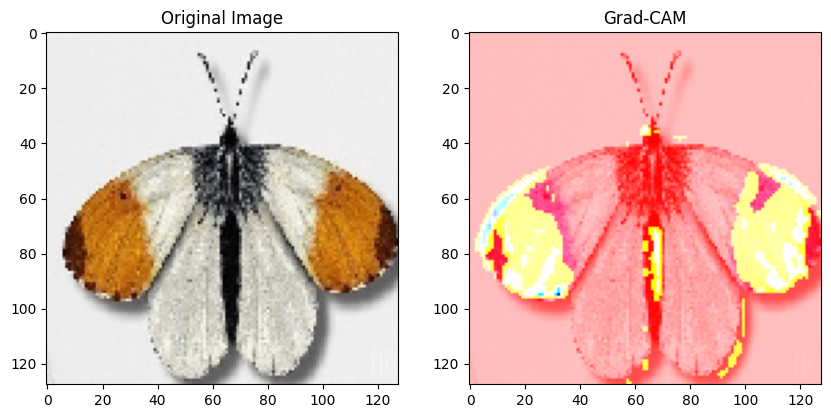

In [22]:
plot_CAM_using_img_name('Image_685.jpg')
plot_CAM_using_img_name('Image_4151.jpg')
plot_CAM_using_img_name('Image_2433.jpg')

Here we notice that the model seems to recognise the white patterns of the butterfly and makes its preciction based on that.